In [1]:
%run '/home/christianl/Zhang-Lab/Zhang Lab Code/Boilerplate/Fig_config_utilities.py'

<class 'numpy.ndarray'> (3187, 16101)


In [2]:
# violin plots and Q-Q plots for residual analysis
def figure_4_residual_distributions(y_true, predictions_dict, 
                                    output_path='/home/christianl/Zhang-Lab/Zhang Lab Code/Figures/'):
    """
    Generate violin plots of residual distributions and Q-Q plots.
    
    Parameters
    ----------
    y_true : array-like, shape (n_samples, n_genes)
        True target values (NOT flattened - function handles it)
    predictions_dict : dict
        Dictionary of predictions by model
    output_path : str
        Path to save figure
        
    Returns
    -------
    dict : Statistics for each model's residuals
    """
    set_publication_style()
    
    # figure with residual distributions and Q-Q plots
    fig = plt.figure(figsize=FIGSIZE_WIDE)
    gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.35)
    
    model_names = list(predictions_dict.keys())
    
    # flattening y_true
    y_true_flat = y_true.ravel()
    
    print("\n" + "="*80)
    print("RESIDUAL DISTRIBUTION ANALYSIS")
    print("="*80)
    
    statistics = {}
    
    for idx, model_name in enumerate(model_names):
        print(f"\nAnalyzing {model_name}...")
        
        # extract predictions then flatten
        y_pred = predictions_dict[model_name]
        y_pred_flat = y_pred.ravel()
        
        # calculate residuals
        residuals = y_true_flat - y_pred_flat
        
        # sampling for stat tests (ie. using large datasets)
        sample_size = min(len(residuals), 5000)
        if len(residuals) > sample_size:
            print(f"  Sampling {sample_size} points for statistical tests (from {len(residuals)} total)")
            sample_indices = np.random.choice(len(residuals), sample_size, replace=False)
            residuals_sample = residuals[sample_indices]
        else:
            residuals_sample = residuals
        
        # calculate statistics
        mean_res = np.mean(residuals)
        std_res = np.std(residuals, ddof=1)
        median_res = np.median(residuals)
        skewness = stats.skew(residuals_sample)
        kurtosis_val = stats.kurtosis(residuals_sample)
        
        # Shapiro-Normality test (on sampling)
        if len(residuals_sample) >= 3:
            shapiro_stat, shapiro_p = stats.shapiro(residuals_sample)
        else:
            shapiro_stat, shapiro_p = np.nan, np.nan
        
        # storing statistics
        statistics[model_name] = {
            'mean': mean_res,
            'std': std_res,
            'median': median_res,
            'skewness': skewness,
            'kurtosis': kurtosis_val,
            'shapiro_stat': shapiro_stat,
            'shapiro_p': shapiro_p
        }
        
        # TOP ROW: Violin plot
        ax1 = fig.add_subplot(gs[0, idx])
        
        # sampling for violin plot (ie. using large datasets)
        if len(residuals) > 50000:
            violin_sample_size = 50000
            violin_indices = np.random.choice(len(residuals), violin_sample_size, replace=False)
            residuals_violin = residuals[violin_indices]
        else:
            residuals_violin = residuals
        
        parts = ax1.violinplot([residuals_violin], positions=[0], widths=0.7,
                              showmeans=True, showmedians=True, showextrema=True)
        
        # coloring models in the violin plot
        for pc in parts['bodies']:
            pc.set_facecolor(MODEL_COLORS.get(model_name, '#1f77b4'))
            pc.set_alpha(0.7)
            pc.set_edgecolor('black')
            pc.set_linewidth(1.5)
        
        # mean and median markers
        if 'cmeans' in parts:
            parts['cmeans'].set_color('red')
            parts['cmeans'].set_linewidth(2)
        if 'cmedians' in parts:
            parts['cmedians'].set_color('black')
            parts['cmedians'].set_linewidth(2)
        
        # Add zero line
        ax1.axhline(y=0, color='darkgreen', linestyle='--', linewidth=2, 
                   alpha=0.7, label='Zero (perfect predictions)')
        
        # Labels and formatting
        ax1.set_ylabel('Residuals', fontsize=11, fontweight='bold')
        ax1.set_title(f'{model_name}', fontsize=12, fontweight='bold')
        ax1.set_xticks([])
        ax1.grid(True, alpha=0.3, axis='y')
        
        # stats labels
        textstr = (f'Mean: {mean_res:.4f}\n'
                  f'Median: {median_res:.4f}\n'
                  f'Std: {std_res:.4f}\n'
                  f'Skewness: {skewness:.3f}\n'
                  f'Kurtosis: {kurtosis_val:.3f}')
        
        ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes,
                fontsize=8, verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.85))
        
        # interpretation for skewness
        interpretation = []
        if abs(skewness) > 0.5:
            direction = "right" if skewness > 0 else "left"
            interpretation.append(f'Skewed {direction}')
        if abs(kurtosis_val) > 1.0:
            tail_type = "heavy" if kurtosis_val > 0 else "light"
            interpretation.append(f'{tail_type.capitalize()} tails')
        
        if interpretation:
            interp_text = '\n'.join(interpretation)
            ax1.text(0.98, 0.02, f'⚠ {interp_text}', transform=ax1.transAxes,
                    fontsize=8, verticalalignment='bottom', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7))
        
        # BOTTOM ROW: Q-Q plot
        ax2 = fig.add_subplot(gs[1, idx])
        
        # sampling for Q-Q plot (ie. using large datasets)
        if len(residuals) > 10000:
            qq_sample_size = 10000
            qq_indices = np.random.choice(len(residuals), qq_sample_size, replace=False)
            residuals_qq = residuals[qq_indices]
        else:
            residuals_qq = residuals
        
        # Q-Q plot
        stats.probplot(residuals_qq, dist="norm", plot=ax2)
        
        # enhancing Q-Q plot appearance
        ax2.get_lines()[0].set_markerfacecolor(MODEL_COLORS.get(model_name, '#1f77b4'))
        ax2.get_lines()[0].set_markeredgecolor('none')
        ax2.get_lines()[0].set_alpha(0.5)
        ax2.get_lines()[0].set_markersize(4)
        ax2.get_lines()[1].set_color('red')
        ax2.get_lines()[1].set_linewidth(2)
        
        ax2.set_title(f'Q-Q Plot: {model_name}', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Theoretical Quantiles', fontsize=10)
        ax2.set_ylabel('Sample Quantiles', fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # adding Shapiro results
        if not np.isnan(shapiro_p):
            if shapiro_p < 0.001:
                p_text = 'p < 0.001'
                normality = '⚠ Non-normal'
                box_color = 'lightsalmon'
            elif shapiro_p < 0.05:
                p_text = f'p = {shapiro_p:.4f}'
                normality = '⚠ Non-normal'
                box_color = 'lightsalmon'
            else:
                p_text = f'p = {shapiro_p:.4f}'
                normality = '✓ Normal'
                box_color = 'lightgreen'
            
            shapiro_text = f'Shapiro-Wilk:\n{p_text}\n{normality}'
            ax2.text(0.05, 0.95, shapiro_text,
                    transform=ax2.transAxes, fontsize=9, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor=box_color, alpha=0.85))
        
        # summary stats
        print(f"  Mean residual: {mean_res:.6f} (should be ~0)")
        print(f"  Std residual: {std_res:.6f}")
        print(f"  Skewness: {skewness:.3f} ({'symmetric' if abs(skewness) < 0.5 else 'skewed'})")
        print(f"  Kurtosis: {kurtosis_val:.3f} ({'normal' if abs(kurtosis_val) < 1 else 'heavy/light tails'})")
        if not np.isnan(shapiro_p):
            print(f"  Shapiro-Wilk p: {shapiro_p:.4f} ({'normal' if shapiro_p > 0.05 else 'non-normal'})")
    
    plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
    print(f"\nFigure 4 saved to {output_path}")
    print("="*80 + "\n")
    plt.show()
    
    return statistics


RESIDUAL DISTRIBUTION ANALYSIS

Analyzing MLR...
  Sampling 5000 points for statistical tests (from 51313887 total)
  Mean residual: -0.000276 (should be ~0)
  Std residual: 0.176866
  Skewness: 0.666 (skewed)
  Kurtosis: 22.402 (heavy/light tails)
  Shapiro-Wilk p: 0.0000 (non-normal)

Analyzing XGBRFRegressor...
  Sampling 5000 points for statistical tests (from 51313887 total)
  Mean residual: -0.203360 (should be ~0)
  Std residual: 0.396277
  Skewness: -0.911 (skewed)
  Kurtosis: 4.110 (heavy/light tails)
  Shapiro-Wilk p: 0.0000 (non-normal)

Figure 4 saved to figure4_v1.png



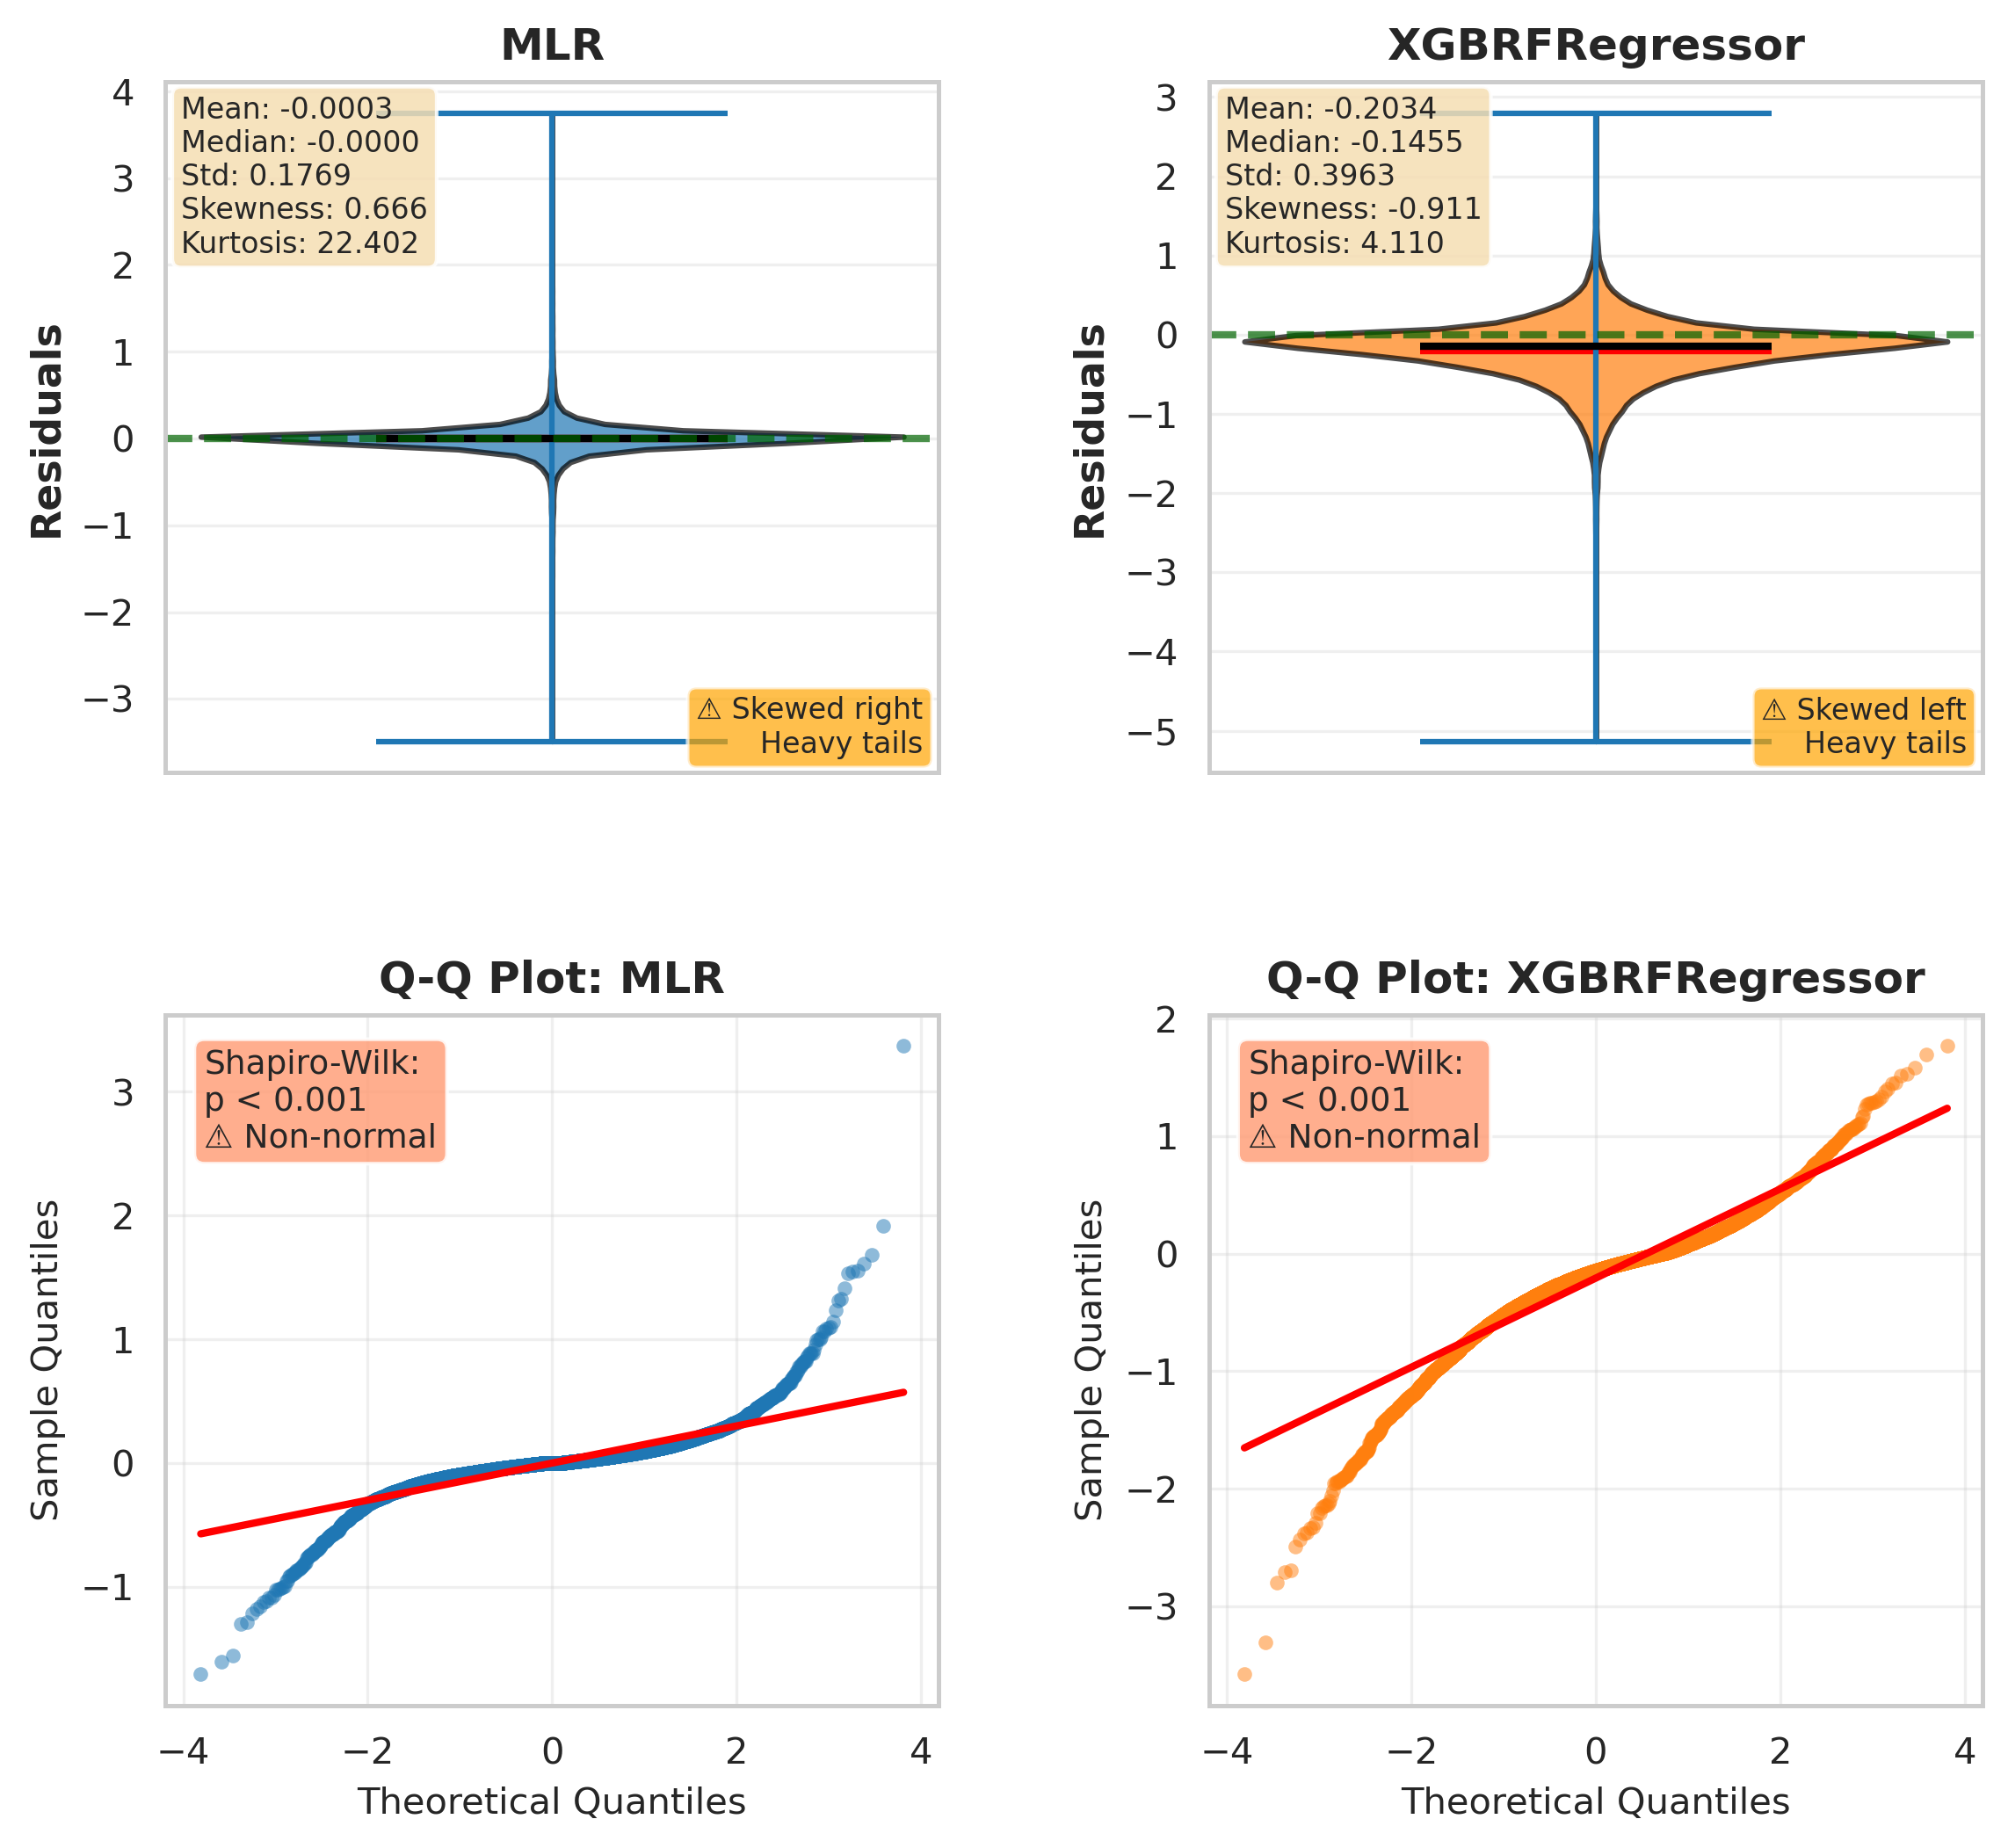

{'MLR': {'mean': np.float64(-0.0002757670053278083),
  'std': np.float64(0.1768656914157687),
  'median': np.float64(-4.440892098500626e-16),
  'skewness': np.float64(0.6661226385637724),
  'kurtosis': np.float64(22.401586690509816),
  'shapiro_stat': np.float64(0.7789019294609814),
  'shapiro_p': np.float64(1.6913802159389915e-63)},
 'XGBRFRegressor': {'mean': np.float64(-0.20335952551121833),
  'std': np.float64(0.3962770943641074),
  'median': np.float64(-0.14551958972404488),
  'skewness': np.float64(-0.9107363584479657),
  'kurtosis': np.float64(4.110275577171915),
  'shapiro_stat': np.float64(0.9220334765641992),
  'shapiro_p': np.float64(4.0930408503547615e-45)}}

In [3]:
figure_4_residual_distributions(y_test_centered,predictions,'figure4_v1.png')